# Qiskit Workshop: Grover's Algorithm and Amplitude Estimation

**Problem**: Find the marked item(s) in a list

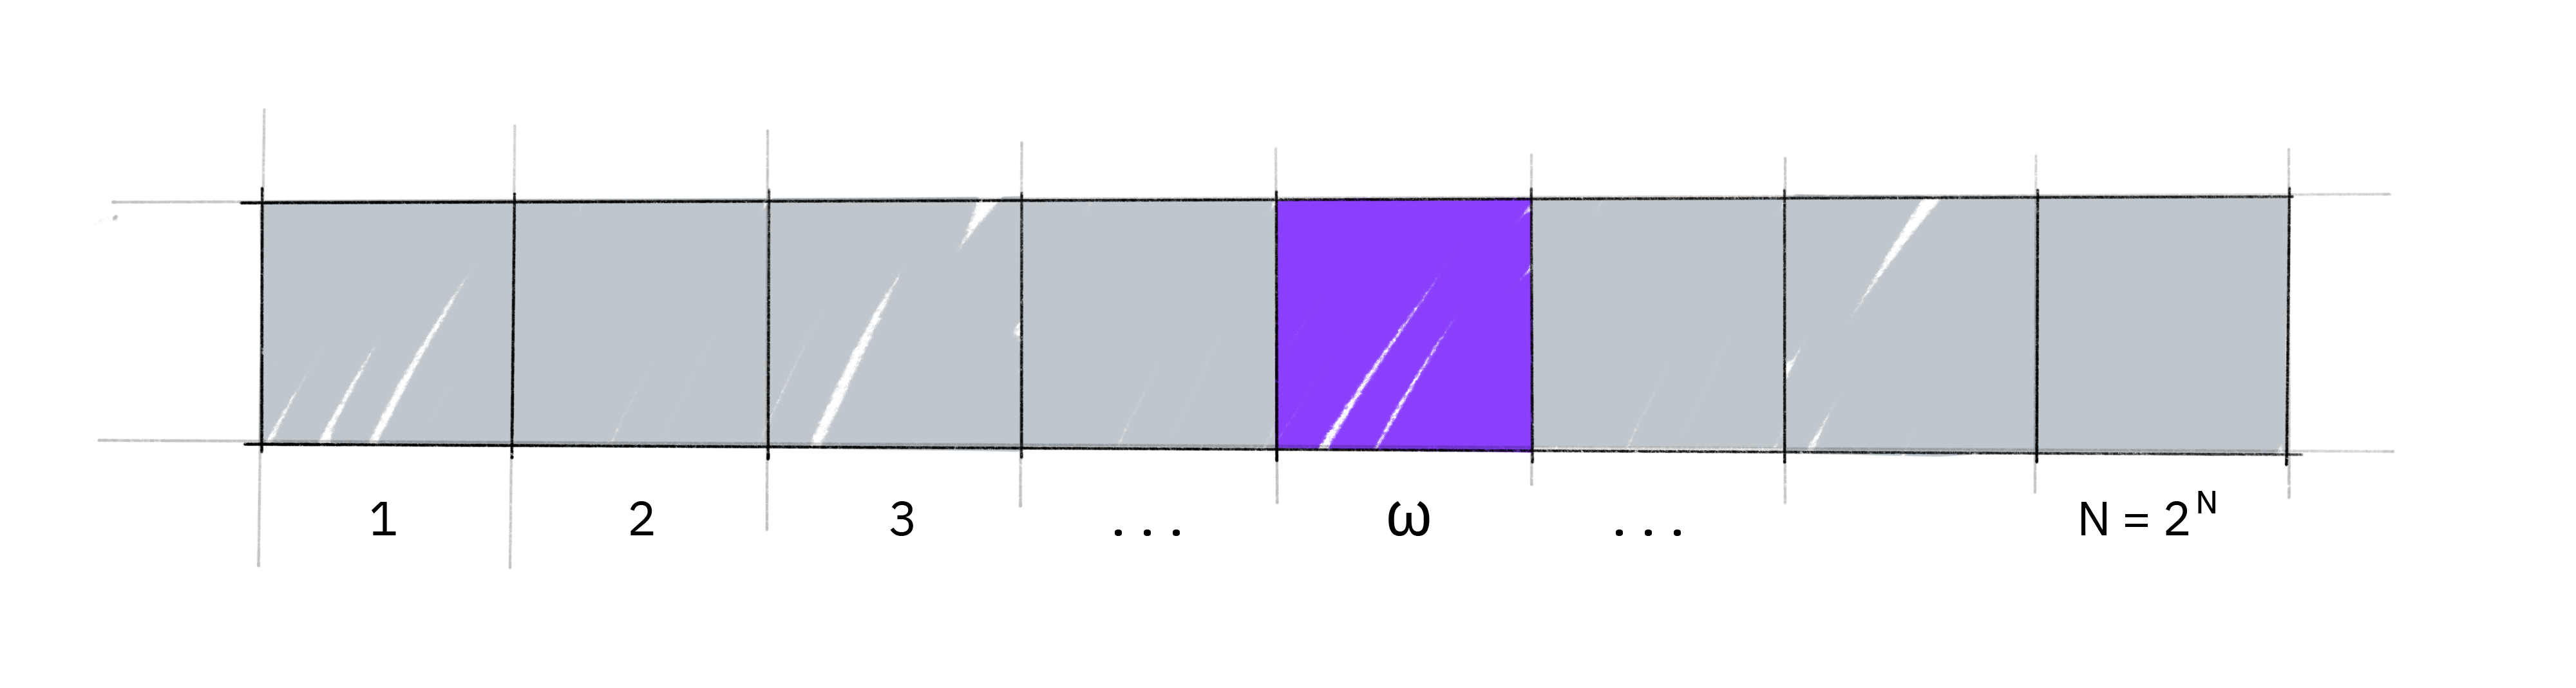

**Solution**: Grover's Algorithm

Steps:
1. Initialize in uniform superposition
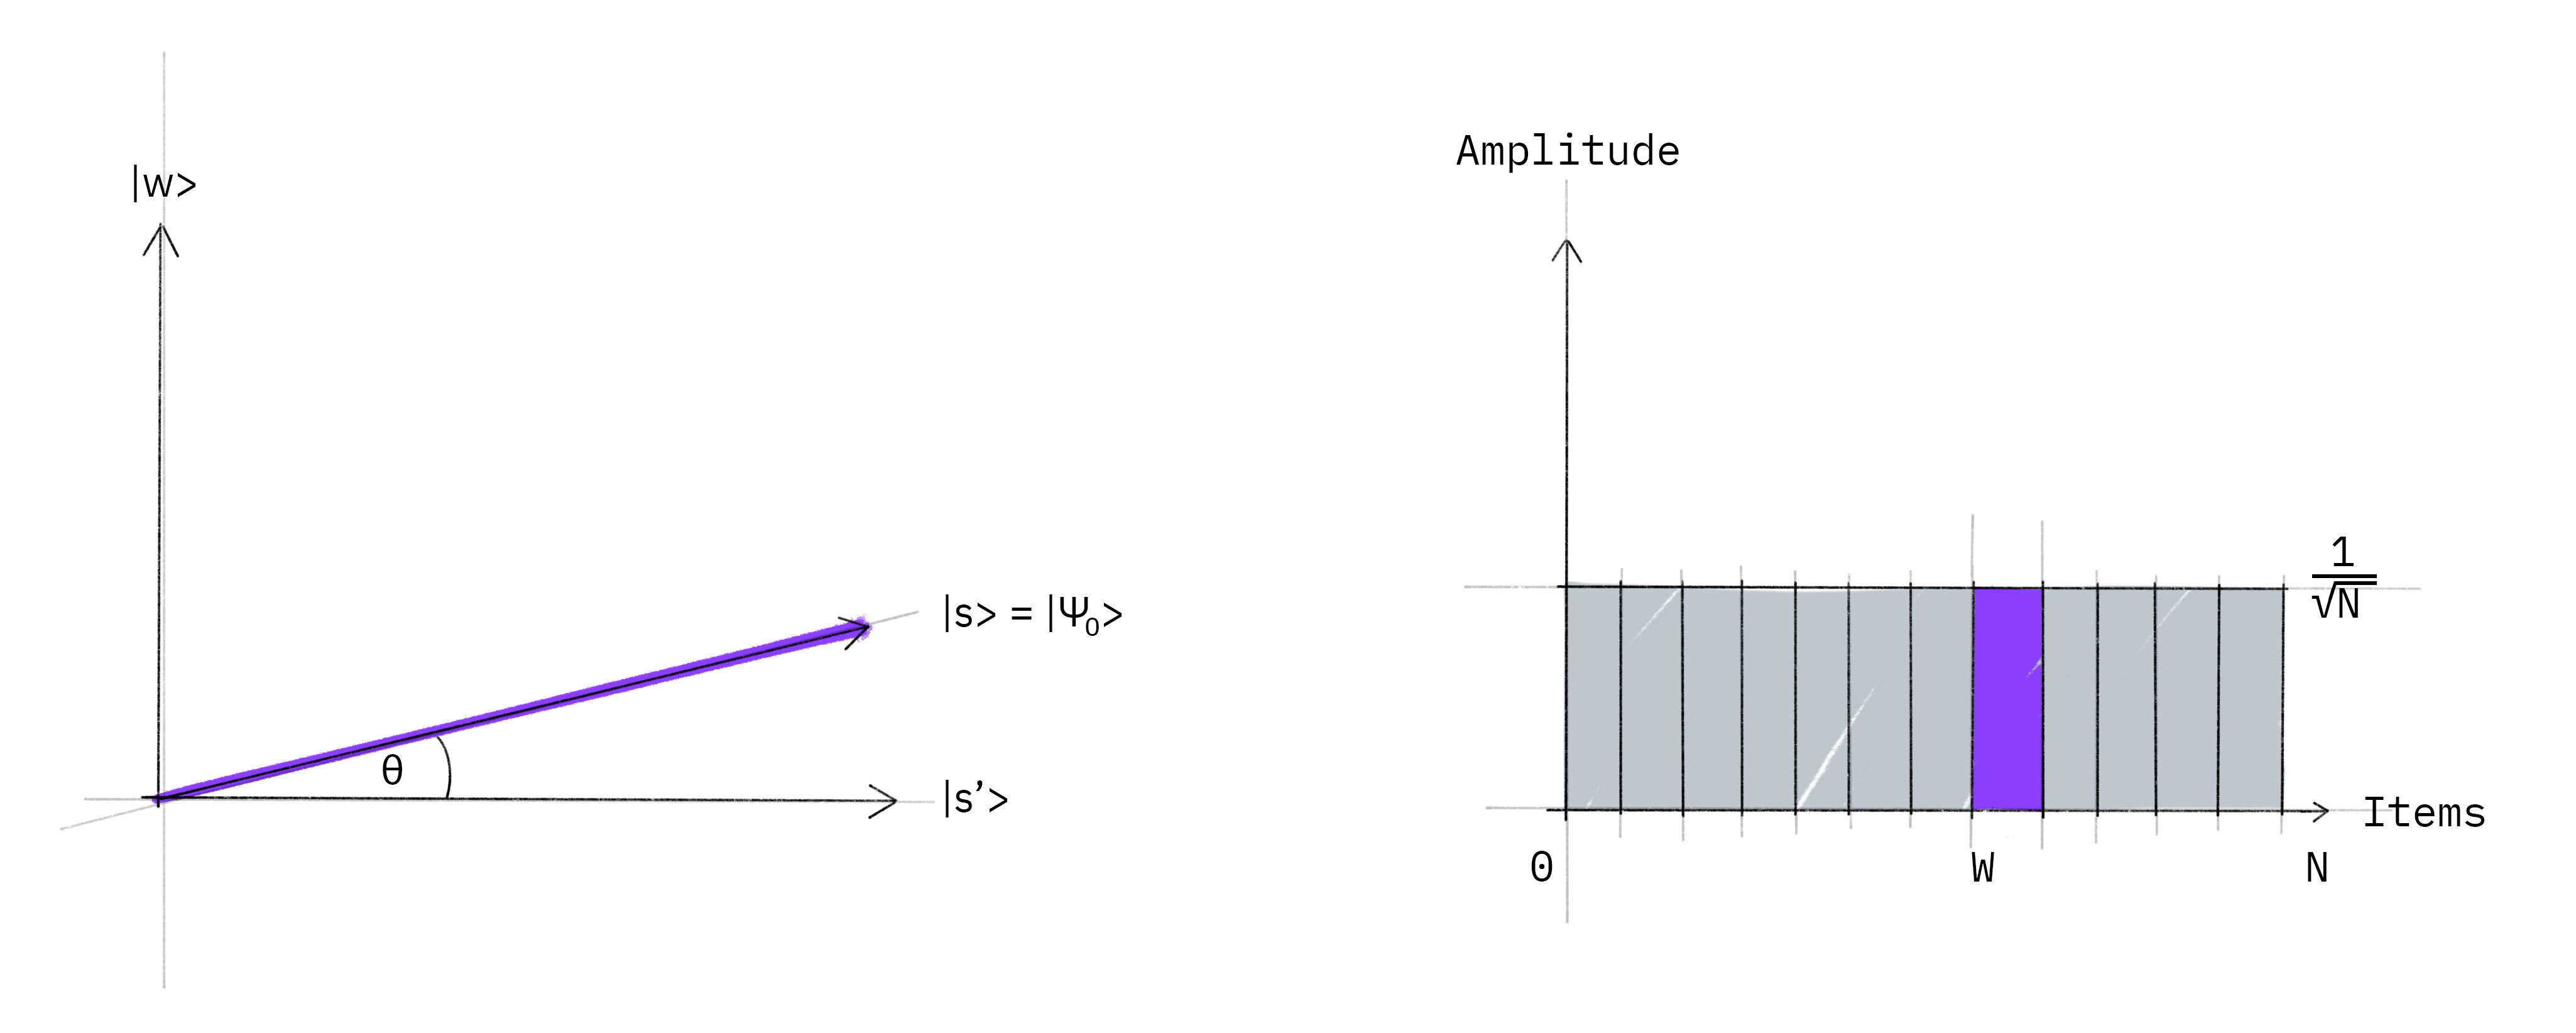
1. Apply Oracle
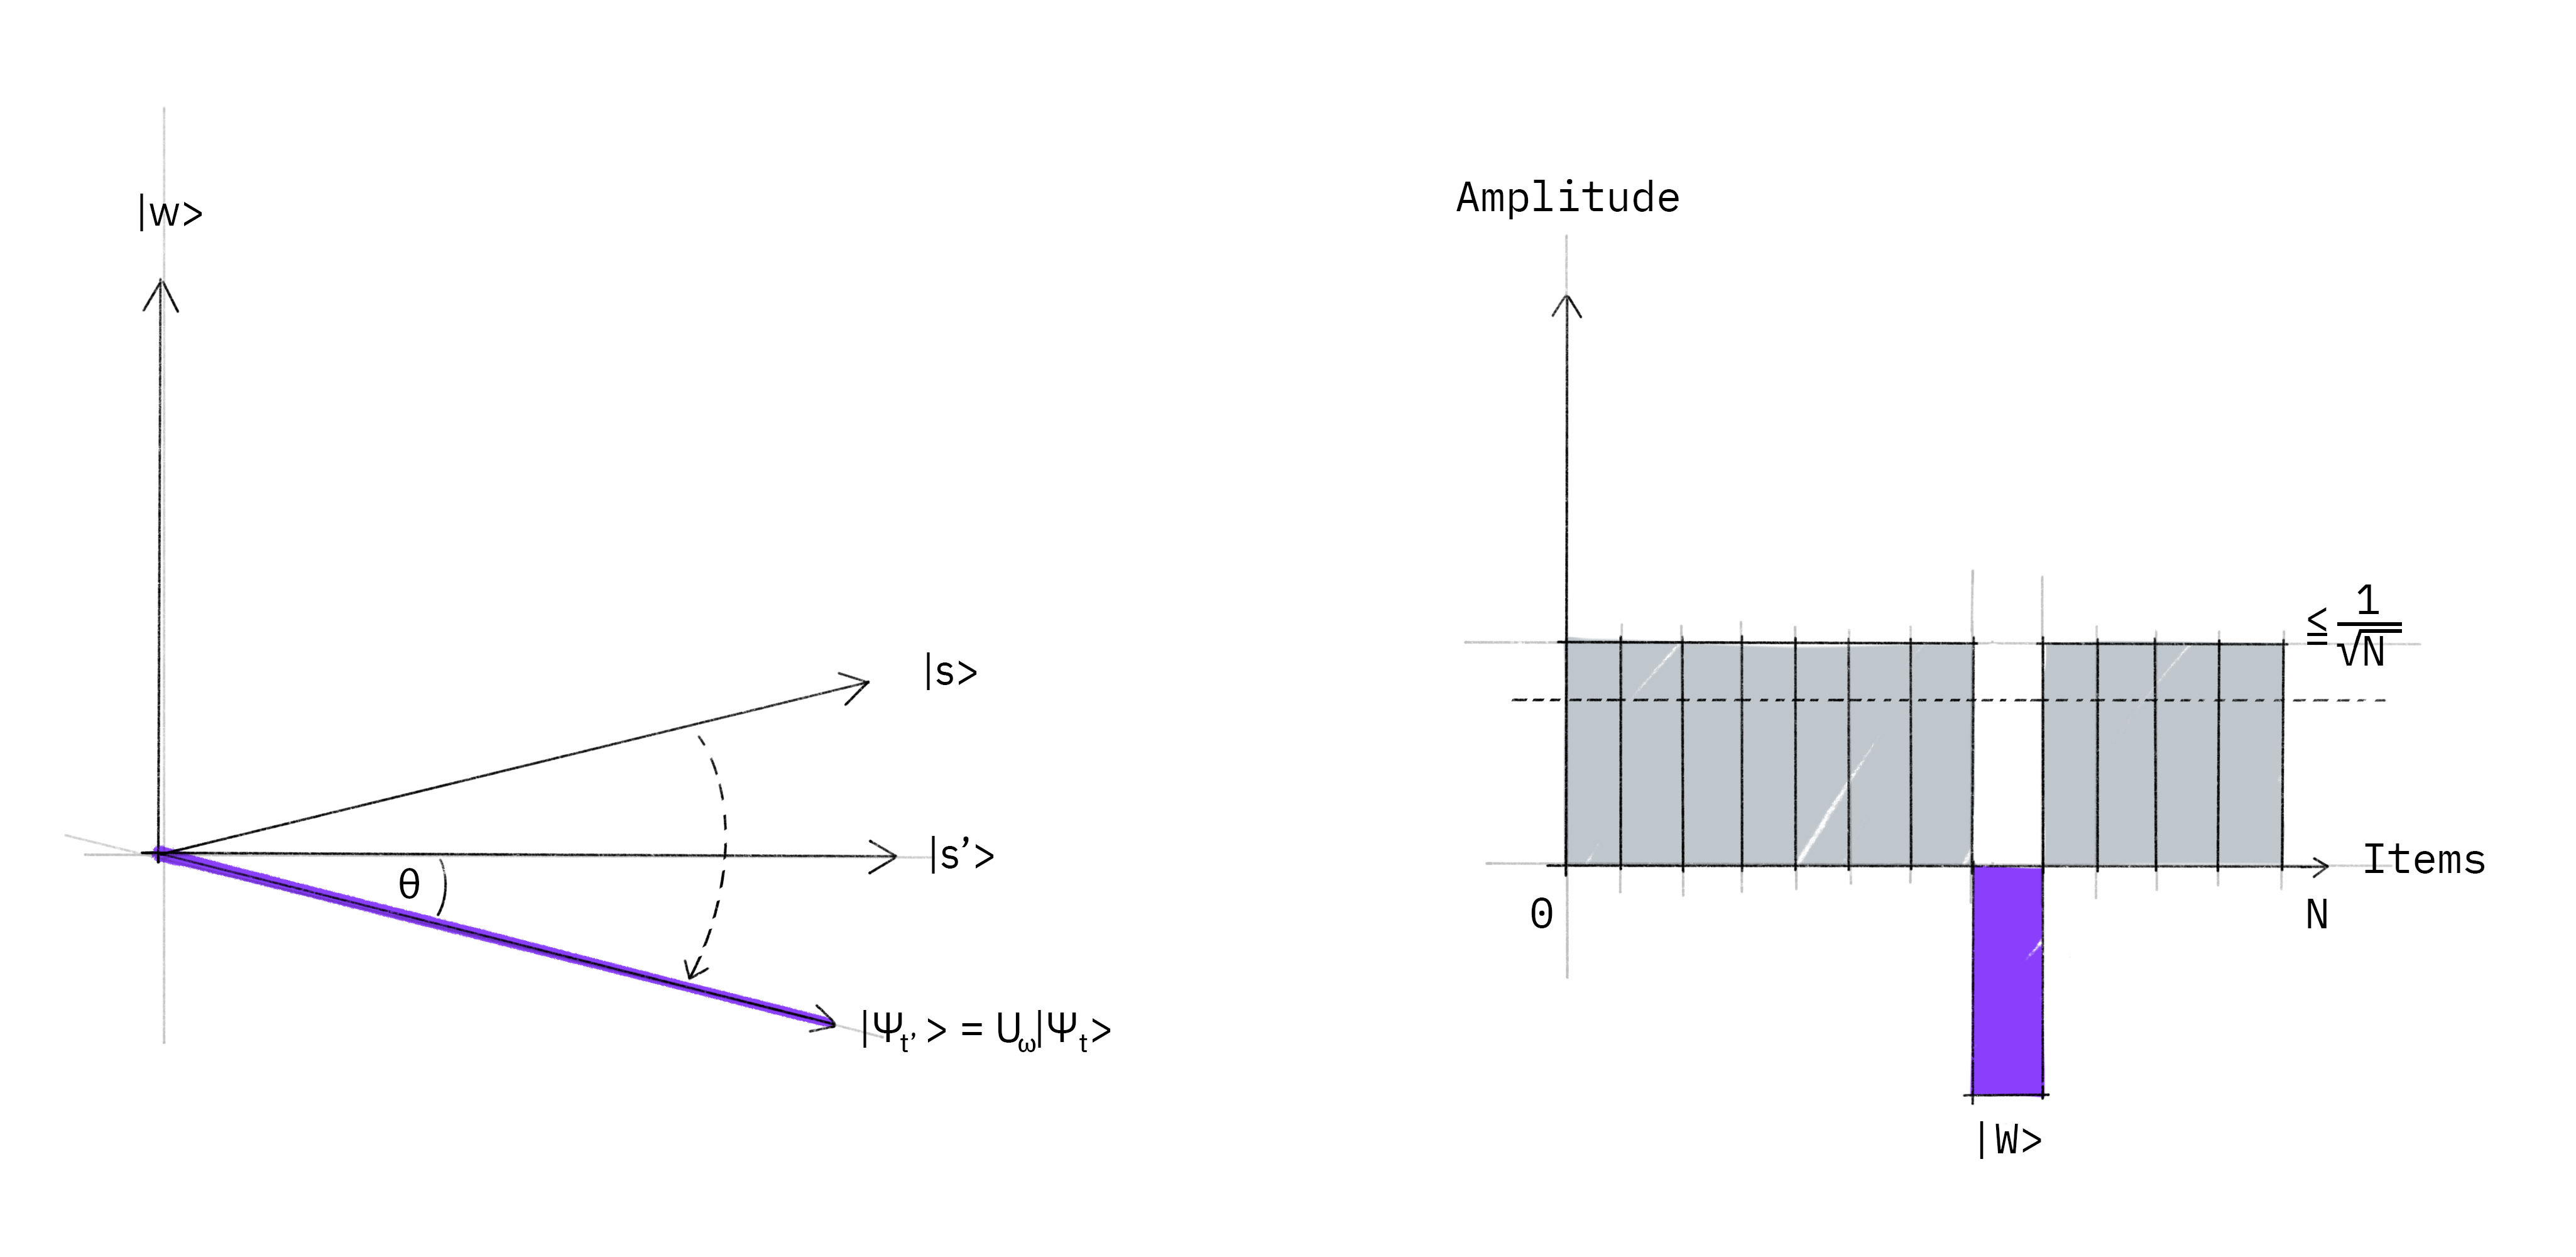
1. Apply second reflection
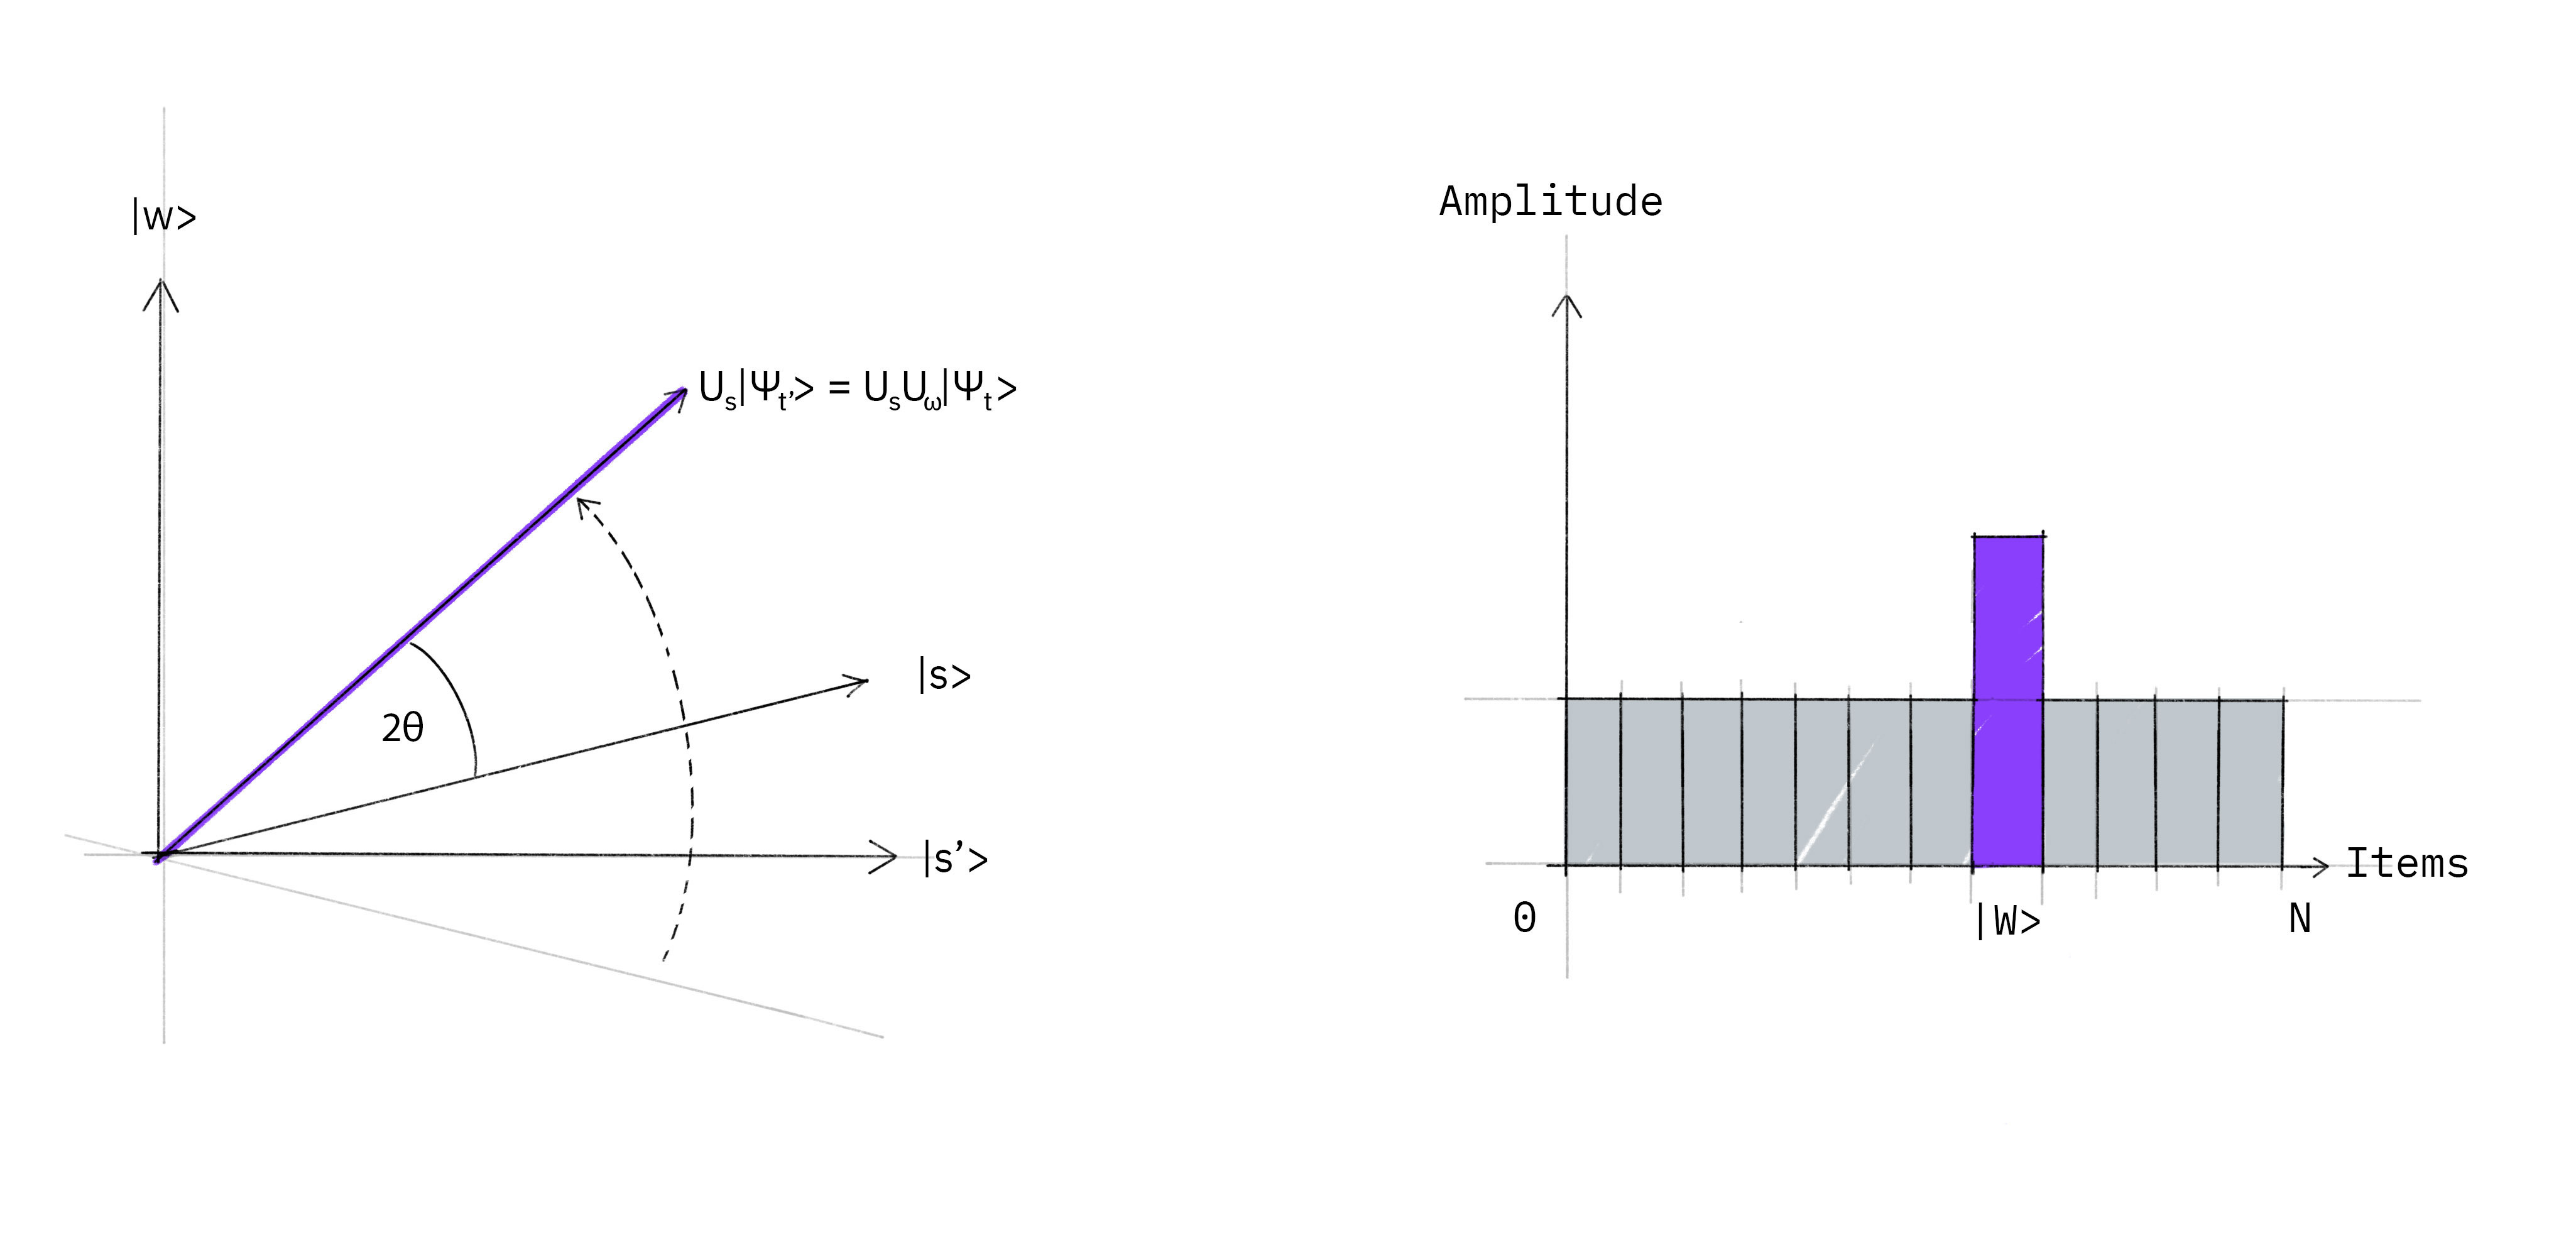
1. Repeat $\frac{\pi}{4}\sqrt{\frac{N}{M}}$ times
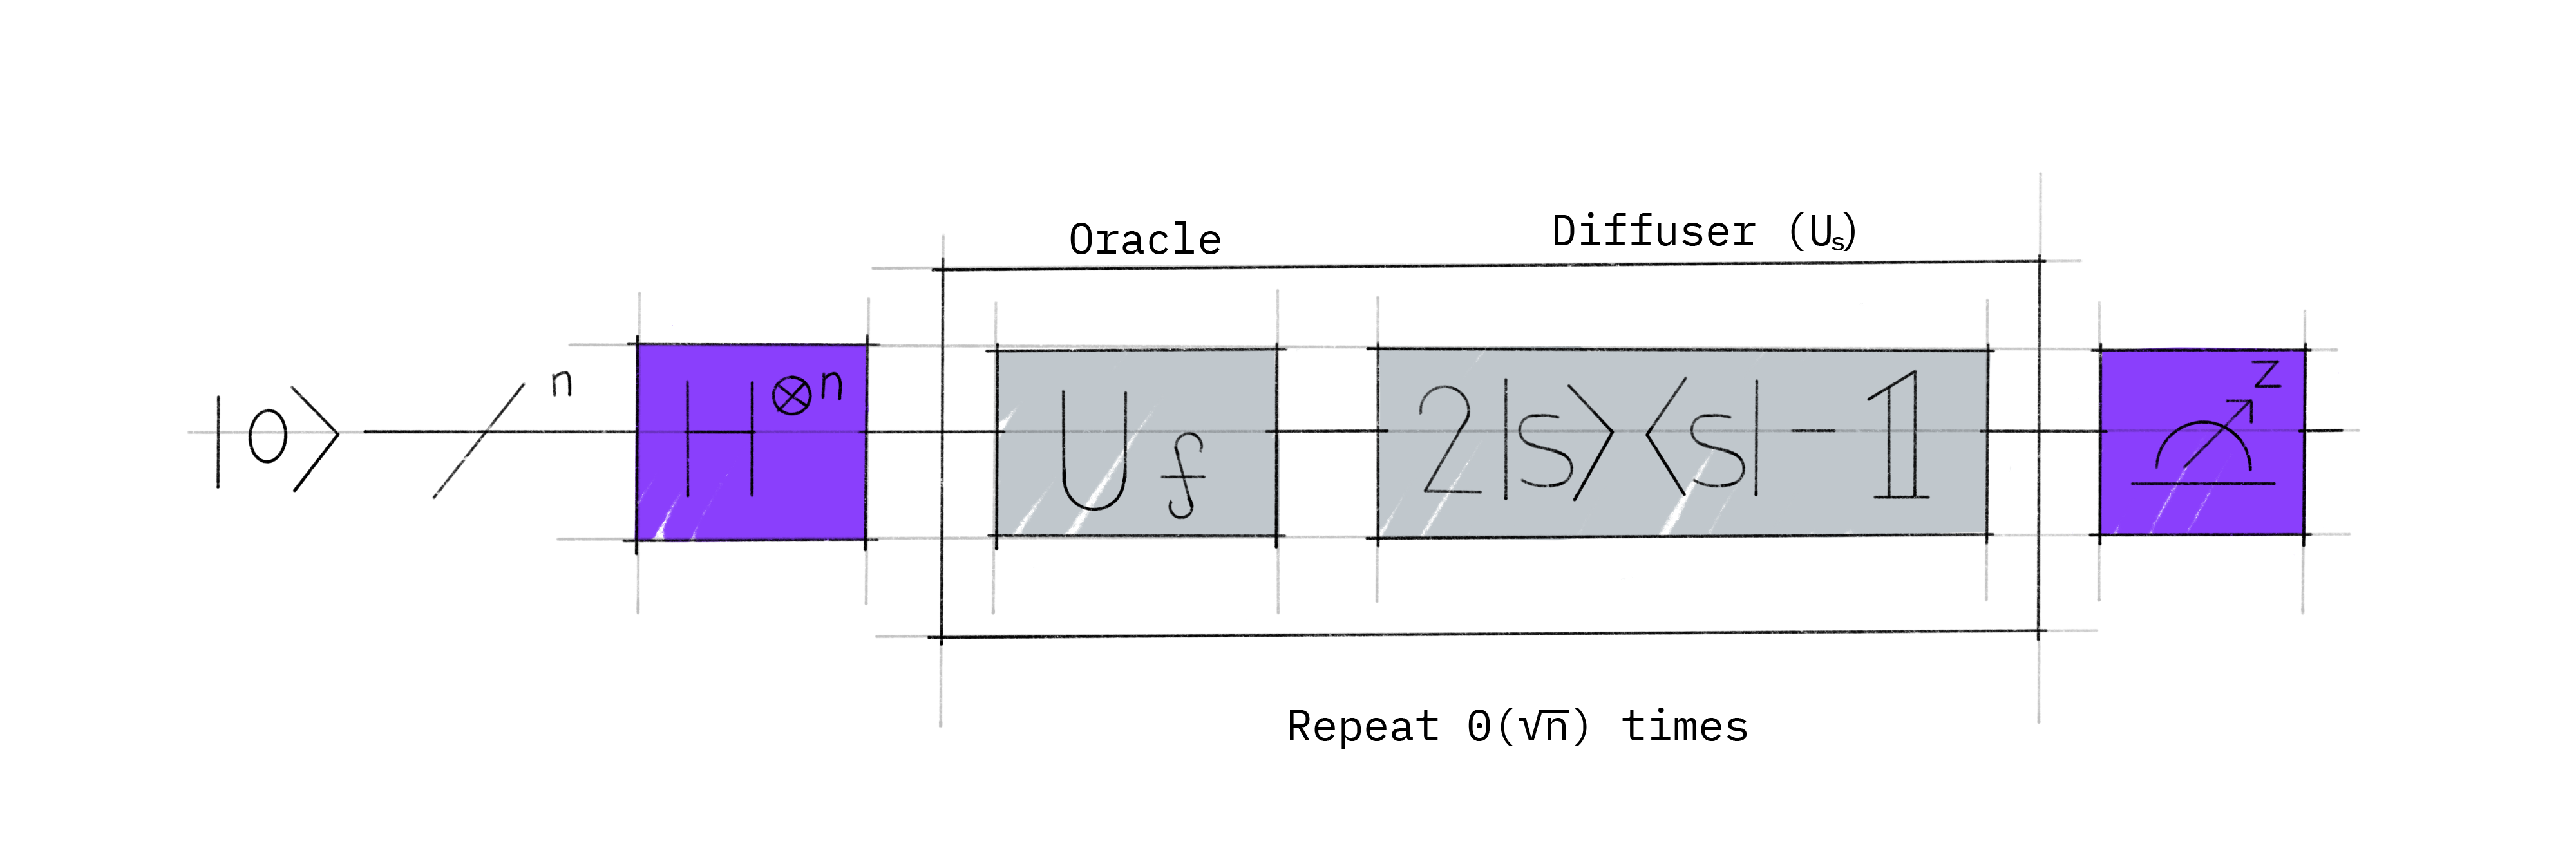

In [ ]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
import warnings
warnings.filterwarnings('ignore')

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, assemble, execute
from qiskit.providers.aer import AerSimulator

import matplotlib.pyplot as plt

## Simple Grover Example

Step 1: Create circuit and initialize in uniform superposition

In [ ]:
def initGrover(nqubits):
    qreg = QuantumRegister(nqubits, 'q')
    circ = QuantumCircuit(qreg, name='init')
    # Create uniform superposition
    circ.h(qreg)
    return circ

initGrover(3).draw()

Step 2: Create the oracle which marks one state with a negative phase

In [ ]:
from qiskit.circuit.library import Diagonal

def makeOracle(nqubits, mark):
    '''
    Generates a phase oracle that applies a negative phase to the state identified by mark.
    The oracle is created using a Diagonal gate from Qiskit
    '''
    # Create an array representing all possible states
    diagonal_elements = np.ones(2**nqubits)
    # Set a negative phase to the marked state
    diagonal_elements[mark] = -1
    # Create a Diagonal gate 
    oracle_gate = Diagonal(diagonal_elements)
    oracle_gate.name = 'Oracle'
    return oracle_gate

makeOracle(3, 3).draw()

Step 3: Create a diffuser circuit to amplify the amplitude of the marked state

In [ ]:
def makeDiffuser(nqubits):
    q = QuantumRegister(nqubits, 'q')
    circ = QuantumCircuit(q, name='U$_s$')
    
    # Transform
    circ.h(q)
    
    # Transform
    circ.x(q)
    
    # Do multicontrolled-Z gate
    circ.h(q[nqubits-1])
    ctrlq = q[0:(nqubits-1)]
    targq = q[nqubits-1]
    circ.mct(ctrlq, targq)
    circ.h(q[nqubits-1])
    
    # Reverse the transformations
    circ.x(q)
    circ.h(q)
    
    return circ

makeDiffuser(3).draw()

Step 4: Assemble the overall circuit applying multiple the Grover iterations

In [ ]:
n = 3
iterations = 2
marked_state = 3

qreg = QuantumRegister(n, 'q')
creg = ClassicalRegister(n, 'c')
qc = QuantumCircuit(qreg, creg)

oracleqc = makeOracle(n, marked_state)
diffuserqc = makeDiffuser(n)

qc.append(initGrover(n), qreg)
# NOTE: REMOVE the save_statevector() lines if running on real device!
for i in range(iterations):
    qc.append(oracleqc, qreg)
    qc.save_statevector(label="oracle"+str(i))
    qc.append(diffuserqc, qreg)
    qc.save_statevector(label="diffuser"+str(i))
    
qc.measure(qreg, creg)
qc.draw()

Simulate!

In [ ]:
def runCirc(circ, backend, optimization_level=None):
    transpiled_circ = transpile(circ, backend, optimization_level=optimization_level)
    job = backend.run(transpiled_circ)
    return job

In [ ]:
result = runCirc(qc, AerSimulator()).result()
counts = result.get_counts()
plot_histogram(counts)

What happens at intermediate points in the circuit?

In [ ]:
def plot_amplitudes(statevec):
    '''
    Plots the real component of the statevector elements
    '''
    # Create the x-axis labels
    compstates = np.linspace(0, len(statevec)-1, len(statevec)).astype(int)
    num_bits = np.log2(len(statevec)).astype(int)
    x = [np.binary_repr(compstate, num_bits) for compstate in compstates]
    # Plot the real component of the statevector
    plt.bar(x=x, height=statevec.real)
    plt.axhline(y=0, color='k', lw=1)
    plt.xticks(rotation='vertical')

In [ ]:
sv = result.data(0)['oracle0']
plot_amplitudes(sv)

The oracle inverts the phase of the marked state relative to other states.

In [ ]:
sv = result.data(0)['diffuser0']
plot_amplitudes(sv)

The diffuser amplified the marked state relative to all other states. Note that the phase of all states is now inverted, which does not matter when the qubits are measured.

In [ ]:
sv = result.data(0)['diffuser1']
plot_amplitudes(sv)

After the second iteration, the marked state is amplified further.

Now, run on an IBM Quantum computer!

In [ ]:
from qiskit.providers.ibmq import least_busy

# Note: for best results, use a system with a quantum volume 16 or 32
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and
                                   not x.configuration().simulator and
                                   x.status().operational==True and
                                   x.configuration().quantum_volume > 8))
print("Least busy device: ", device)

In [ ]:
%qiskit_job_watcher

In [ ]:
# Note: regenerate circuit without the save_statevector() before running on the real quantum computer
ibmq_job = runCirc(qc, device, optimization_level=3)

In [ ]:
counts = ibmq_job.result().get_counts()
plot_histogram(counts)

## Using Qiskit's Grover Class

In [ ]:
n = 3
good_state = 3
oracle = makeOracle(n, good_state)

Previous API:

In [ ]:
from qiskit.aqua.algorithms import Grover
from qiskit.aqua import QuantumInstance as AquaQuantumInstance

backend = Aer.get_backend('statevector_simulator')
aqua_qinstance = AquaQuantumInstance(backend)
grover = Grover(oracle, good_state=[good_state], quantum_instance=aqua_qinstance)

New API:

In [ ]:
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.utils import QuantumInstance

backend = AerSimulator()
qinstance = QuantumInstance(backend)

# Create an instance of the problem
problem = AmplificationProblem(oracle=oracle, is_good_state=lambda x: x==good_state)

# Use instance of Grover class to solve the problem
grover = Grover(quantum_instance=qinstance)
result = grover.amplify(problem)
print(result.top_measurement)

Create oracles from logical expressions

In [ ]:
# Note: the PhaseOracle class uses the optional tweedledum library that must be installed manually
!pip install tweedledum

In [ ]:
from qiskit.circuit.library import PhaseOracle

# previous API: qiskit.aqua.components.oracles.LogicalExpressionOracle
oracle = PhaseOracle('x & y & ~z')

problem = AmplificationProblem(oracle=oracle, is_good_state=oracle.evaluate_bitstring)
grover = Grover(quantum_instance=qinstance)
grover_qc = grover.construct_circuit(problem, 1)
grover_qc.decompose().draw()

In [ ]:
result = grover.amplify(problem)
print(result)

In [ ]:
plot_histogram(result.circuit_results[5])

## Amplitude Amplification
What if we have some information about the good states? Instead of uniform superposition, initialize only specific states, then use Amplitude Amplification from Grover's algorithm to find solutions.

In [ ]:
# Do state preparation that only initializes a subset of the states
# in which we know the answer exists (|01>, |10>, and |11>)
theta = 2 * np.arccos(1 / np.sqrt(3))
state_preparation = QuantumCircuit(2)
state_preparation.ry(theta, 0)
state_preparation.ch(0,1)
state_preparation.x(1)
#state_preparation.h(2)
state_preparation.draw()

In [ ]:
# Test the state prep circuit and examine the states that are present
state_prep_test = state_preparation.copy()
state_prep_test.save_statevector()
result = runCirc(state_prep_test, AerSimulator()).result()
sv = result.get_statevector()
plot_amplitudes(sv)

In [ ]:
# Create an oracle circuit that marks |11>
oracle = QuantumCircuit(3)
oracle.h(2)
oracle.ccx(0,1,2)
oracle.h(2)
oracle.draw()

In [ ]:
problem_aa = AmplificationProblem(oracle=oracle, state_preparation=state_preparation, objective_qubits=[0,1], is_good_state=['11'])
grover_aa = Grover(quantum_instance=qinstance)

In [ ]:
result = grover_aa.amplify(problem_aa)
print('Success!' if result.oracle_evaluation else 'Failure!')
print(result.top_measurement)

In [ ]:
grover_aa_qc = grover.construct_circuit(problem_aa, 2)
grover_aa_qc.decompose().draw()

<br>

---

## Amplitude Estimation

**Problem:** Suppose we have a an operator $A$ that results in the following state:

<center>
    $A |0 \rangle_n |0\rangle = \sqrt{1-a} |\psi_0\rangle_n |0\rangle + \sqrt{a} |\psi_1\rangle_n |1\rangle$
</center>

where 

<center>
    $|\psi_1\rangle_n$ are "good states"
</center>
<center>
$|\psi_0\rangle_n$ are "bad states"
</center>

Find $a$

**Solution**: Use an amplitude estimation algorithm

**Variants:**
- Original - Quantum Amplitude Amplification and Estimation. [arXiv:quant-ph/0005055](http://arxiv.org/abs/quant-ph/0005055) (uses QPE)
- Iterative - Iterative Quantum Amplitude Estimation. [arXiv:1912.05559](https://arxiv.org/abs/1912.05559) (does not use QPE)

### Step 0: Define some parameters

In [ ]:
n_qubits = 3

### Step 1: Define $A$

In this example, use a normal probability distribution to put some amplitudes on each of the possible states.

**Old API**

In [ ]:
# Apply normal probability distribution to state regster
from qiskit.circuit.library import NormalDistribution

ndist = NormalDistribution(n_qubits, mu=1, sigma=0.25, bounds=(0,2))

**New API**

In [ ]:
from qiskit_finance.circuit.library import NormalDistribution

dist = NormalDistribution(n_qubits, mu=1, sigma=0.25, bounds=(0,2))

Quickly check on what the distribution looks like

In [ ]:
dist_cp = dist.copy()
dist_cp.add_register(ClassicalRegister(n_qubits))
dist_cp.save_statevector()
dist_cp.measure([0,1,2],[0,1,2])
job = runCirc(ndist_cp, AerSimulator())
plot_histogram(job.result().get_counts())

Now, mark some "good" states

In [ ]:
def markGoodStates(n):
    qc = QuantumCircuit(n+1)

    # Mark the |x100> state as good
    qc.x(1)
    qc.x(0)
    qc.mct([0,1,2], n)
    qc.x(0)
    qc.x(1)

    # Mark the |x110> as good
    qc.x(0)
    qc.mct([0,1,2], n)
    qc.x(0)
    
    return qc

markGoodStates(n_qubits).draw()

Now, create $A$ circuit

In [ ]:
A = QuantumCircuit(n_qubits+1)
A.append(dist, range(n_qubits))
A.append(markGoodStates(n_qubits), range(n_qubits+1))
A.draw()

### Step 2: Apply the Amplitude Estimation algorithm

**Old API**

In [ ]:
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.aqua import QuantumInstance as AquaQuantumInstance

A_gate = A.decompose()

aqua_qinstance = AquaQuantumInstance(AerSimulator())

qae_old = AmplitudeEstimation(4, A_gate, quantum_instance=aqua_qinstance)
result = qae_old.run()

In [ ]:
print(result.mle)

**New API**

In [ ]:
from qiskit.algorithms import AmplitudeEstimation, EstimationProblem
from qiskit.utils import QuantumInstance

A_gate = A.decompose()

problem_ae = EstimationProblem(state_preparation=A_gate, objective_qubits=[n_qubits])

qinstance = QuantumInstance(AerSimulator())

qae = AmplitudeEstimation(4, quantum_instance=qinstance)

In [ ]:
qae_circ = qae.construct_circuit(problem_ae)
qae_circ.draw('mpl')

In [ ]:
result = qae.estimate(problem_ae)
print(result.mle)

### Step 2 (alternate): Use iterative amplitude estimation algorithm

In [ ]:
from qiskit.algorithms import IterativeAmplitudeEstimation

iqae = IterativeAmplitudeEstimation(epsilon_target=0.01, alpha=0.5, quantum_instance=qinstance)

In [ ]:
iqae_circ = iqae.construct_circuit(problem_ae, k=1)
iqae_circ.draw()

In [ ]:
result_iqae = iqae.estimate(problem_ae)
print(result_iqae.estimation)